# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [58]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [142]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [143]:
class GroceryStoreDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [144]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from functools import partial
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import io
import tqdm

In [145]:
!rm -r runs/*

zsh:1: no matches found: runs/*


In [159]:
config = {
    "num_epochs": 20,
    "lr": 1e-3,
    "batch_size": 32,
    "ls": 0.01,
    "weight_decay": 0.1
}

In [160]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.RandomResizedCrop(size=(384, 384), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
])

transform_no_augmentation = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
])

train_dataset = GroceryStoreDataset("train", transform=transform)
val_dataset = GroceryStoreDataset("val", transform=transform_no_augmentation)
test_dataset = GroceryStoreDataset("test", transform=transform_no_augmentation)

In [161]:
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

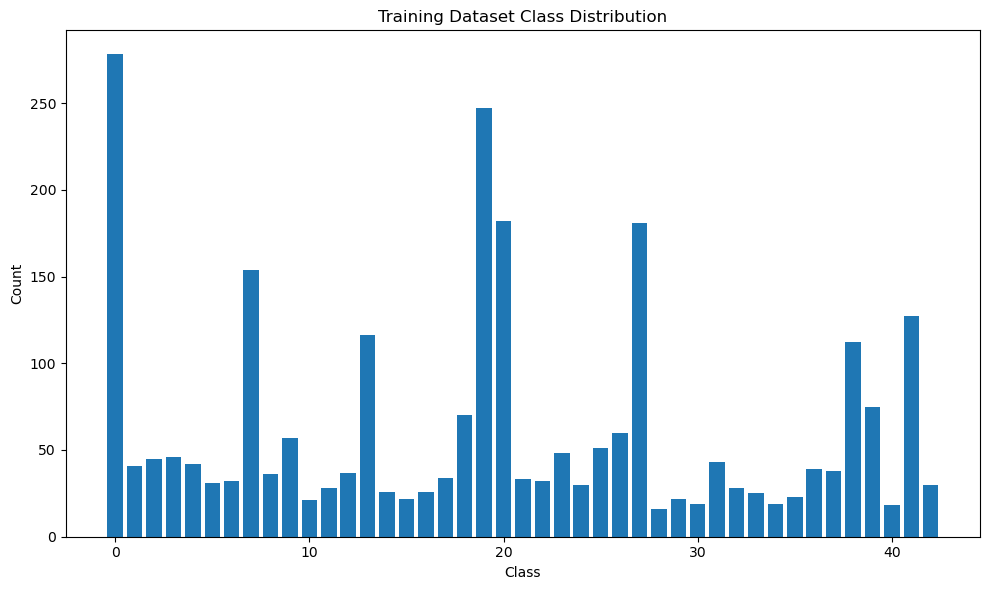

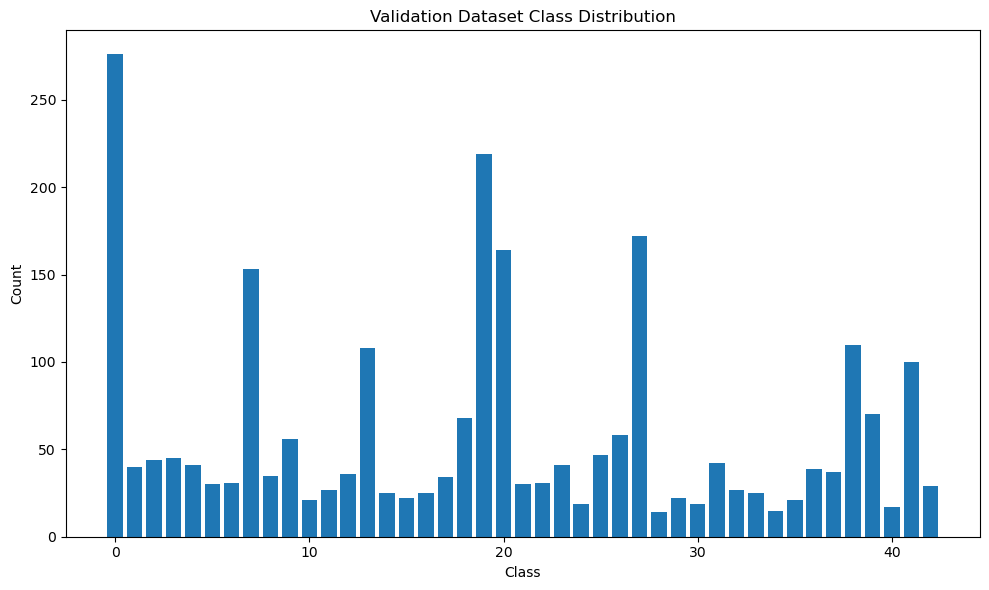

In [162]:
def plot_class_distribution(dataset, title="Class Distribution"):
    class_count = {}
    for _, label in dataset:
        class_count[label] = class_count.get(label, 0) + 1
    
    labels = list(class_count.keys())
    counts = list(class_count.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, title="Training Dataset Class Distribution")
plot_class_distribution(test_dataset, title="Validation Dataset Class Distribution")

In [163]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [164]:
set(img.shape for img, _ in test_dataset)

{torch.Size([3, 348, 348]),
 torch.Size([3, 348, 464]),
 torch.Size([3, 464, 348])}

In [165]:
len(train_dataset)

2640

In [172]:
class ConvBnRelu(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        kernel_size: int,
        use_bn: bool = True,
        act: nn.Module = nn.ReLU(inplace=True),
        **kwargs
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_features,
            out_features,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            **kwargs
        )
        self.norm = nn.BatchNorm2d(out_features) if use_bn else nn.Identity()
        self.act = act if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

Conv1X1BnRelu = partial(ConvBnRelu, kernel_size=1)
Conv3X3BnRelu = partial(ConvBnRelu, kernel_size=3)

class ResBlock(nn.Module):
    def __init__(
        self, 
        in_features, 
        out_features,
        stride = 1,
    ):
        super().__init__()
        reduced_features = out_features // 4
        
        self.block = nn.Sequential(
            Conv1X1BnRelu(in_features, reduced_features),
            Conv3X3BnRelu(reduced_features, reduced_features, stride=stride),
            Conv1X1BnRelu(reduced_features, out_features, act=None)
        )
        self.relu = nn.ReLU(inplace=True)
        self.skip = nn.Identity()
        if stride != 1 or in_features != out_features:
            self.skip = nn.Sequential(
                nn.Conv2d(in_features, out_features, 1, stride),
                nn.BatchNorm2d(out_features)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.block(x) + identity
        return self.relu(out)

In [173]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self.make_layer(64, 128, 1, num_blocks[0])
        self.layer2 = self.make_layer(128, 256, 2, num_blocks[1])
        self.layer3 = self.make_layer(256, 512, 2, num_blocks[2])
        self.layer4 = self.make_layer(512, 1024, 2, num_blocks[3])
        self.classifier = nn.Conv2d(1024, num_classes, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)
        
    def make_layer(self, in_features, out_features, stride, num_blocks):
        layers = []
        layers.append(ResBlock(in_features, out_features, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_features, out_features))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.classifier(out)  # Shape: [batch_size, num_classes, h, w]
        # out = F.adaptive_avg_pool2d(out, (1, 1))  # Shape: [batch_size, num_classes, 1, 1]
        # out = out.view(out.size(0), -1)  # Flatten to [batch_size, num_classes]
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    
model = ResNet([2, 2, 2, 2], num_classes=train_dataset.get_num_classes())
model.to(device)

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): ConvBnRelu(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU(inplace=True)
        )
        (1): ConvBnRelu(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU(inplace=True)
        )
        (2): ConvBnRelu(
          (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          (norm): BatchNorm2d(128, ep

In [178]:
def plot_confusion_matrix(cm, class_names):
  num_classes = len(class_names)
  fig, ax = plt.subplots(figsize=(max(8, num_classes * 0.7), max(6, num_classes * 0.7)))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.set_title("Confusion matrix", fontsize=20)
  tick_marks = np.arange(num_classes)
  ax.set_xticks(tick_marks)
  ax.set_yticks(tick_marks)
  plt.xticks(fontsize=18, rotation=90)
  plt.yticks(fontsize=18)


  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_normalized = np.nan_to_num(cm_normalized)
  
  thresh = cm.max() / 2.
  for i, j in np.ndindex(cm.shape):
      ax.text(j, i, f"{cm[i, j]}\n({cm_normalized[i, j]:.2f})",
              horizontalalignment="center",
              verticalalignment="center",
              fontsize=max(6, 10 - 0.3 * num_classes),  # Adjust font size based on number of classes
              color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  ax.set_ylabel('True label')
  ax.set_xlabel('Predicted label')

  buf = io.BytesIO()
  plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
  plt.close(fig)
  buf.seek(0)

  image = Image.open(buf)
  return image 

In [179]:
def train_model(config, model, train_loader, val_loader, loss_fn, optimizer, class_names=None):
    writer = SummaryWriter(log_dir=config.get('tensorboard_log_dir', './logs'))

    best_val_acc = 0.0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm.tqdm(train_loader, total=len(train_loader)) as pbar:
            for batch_idx, (inputs, labels) in enumerate(pbar):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                # Backward
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, pred = outputs.max(1)
                total += labels.size(0)
                correct += pred.eq(labels).sum().item()

                train_loss = running_loss / (batch_idx + 1)
                train_acc = correct / total

                global_step = epoch * len(train_loader) + batch_idx
                writer.add_scalar('Loss/Train_Step', loss.item(), global_step)
                writer.add_scalar('Accuracy/Train_Step', pred.eq(labels).sum().item() / labels.size(0), global_step)
    
                pbar.set_postfix({
                        'Epoch': f"{epoch+1}/{config['num_epochs']}",
                        'train_loss': f"{train_loss:.4f}",
                        'train_acc': f"{train_acc:.4f}"
                })

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            val_loss, val_acc, all_preds, all_labels = eval_model(model, val_loader, loss_fn)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            print(f"Epoch [{epoch+1}/{config['num_epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            writer.add_scalar('Loss/Train_Epoch', train_loss, epoch)
            writer.add_scalar('Accuracy/Train_Epoch', train_acc, epoch)
            writer.add_scalar('Loss/Validation_Epoch', val_loss, epoch)
            writer.add_scalar('Accuracy/Validation_Epoch', val_acc, epoch)

            if class_names is not None:
                cm = confusion_matrix(all_labels, all_preds)
                img = plot_confusion_matrix(cm, class_names)
                transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
                img_tensor = transform(img)
                writer.add_image('Confusion Matrix', img_tensor, epoch, dataformats='CHW')

            # if val_acc > best_val_acc:
            #     best_val_acc = val_acc
            #     epochs_no_improve = 0
            #     torch.save(model.state_dict(), f'../models/best_model.pch')
            #     print("Model saved!")
            # else:
            #     epochs_no_improve += 1

            # if epochs_no_improve >= config['patience']:
            #     print("Early stopping!")
            #     break
            
    writer.close()
    return train_losses, train_accuracies, val_losses, val_accuracies
            
def eval_model(model, dataloader, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)
    val_acc = correct / total 

    return val_loss, val_acc, all_preds, all_labels

In [180]:
loss = nn.CrossEntropyLoss(label_smoothing=config["ls"])
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

In [181]:
train_model(config, model, train_loader, val_loader, loss, optimizer, range(0, train_dataset.get_num_classes()))

100%|██████████| 83/83 [00:44<00:00,  1.88it/s, Epoch=1/20, train_loss=1.9212, train_acc=0.4348]


Epoch [1/20], Train Loss: 1.9212, Train Acc: 0.4348, Val Loss: 3.5058, Val Acc: 0.3243


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:45<00:00,  1.83it/s, Epoch=2/20, train_loss=1.6474, train_acc=0.4890]


Epoch [2/20], Train Loss: 1.6474, Train Acc: 0.4890, Val Loss: 2.4861, Val Acc: 0.3209


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:46<00:00,  1.77it/s, Epoch=3/20, train_loss=1.5647, train_acc=0.5261]


Epoch [3/20], Train Loss: 1.5647, Train Acc: 0.5261, Val Loss: 2.4223, Val Acc: 0.3311


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:45<00:00,  1.82it/s, Epoch=4/20, train_loss=1.5023, train_acc=0.5458]


Epoch [4/20], Train Loss: 1.5023, Train Acc: 0.5458, Val Loss: 1.7433, Val Acc: 0.4899


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:45<00:00,  1.83it/s, Epoch=5/20, train_loss=1.3713, train_acc=0.5708]


Epoch [5/20], Train Loss: 1.3713, Train Acc: 0.5708, Val Loss: 2.1554, Val Acc: 0.3682


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:46<00:00,  1.77it/s, Epoch=6/20, train_loss=1.2568, train_acc=0.6345]


Epoch [6/20], Train Loss: 1.2568, Train Acc: 0.6345, Val Loss: 2.7757, Val Acc: 0.3919


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:47<00:00,  1.76it/s, Epoch=7/20, train_loss=1.2813, train_acc=0.6277]


Epoch [7/20], Train Loss: 1.2813, Train Acc: 0.6277, Val Loss: 2.5503, Val Acc: 0.3716


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:47<00:00,  1.76it/s, Epoch=8/20, train_loss=1.2181, train_acc=0.6413]


Epoch [8/20], Train Loss: 1.2181, Train Acc: 0.6413, Val Loss: 2.7446, Val Acc: 0.3953


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:46<00:00,  1.78it/s, Epoch=9/20, train_loss=1.1348, train_acc=0.6640]


Epoch [9/20], Train Loss: 1.1348, Train Acc: 0.6640, Val Loss: 2.0469, Val Acc: 0.4899


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:48<00:00,  1.71it/s, Epoch=10/20, train_loss=1.0637, train_acc=0.6955]


Epoch [10/20], Train Loss: 1.0637, Train Acc: 0.6955, Val Loss: 2.4945, Val Acc: 0.3851


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:45<00:00,  1.82it/s, Epoch=11/20, train_loss=1.0408, train_acc=0.6951]


Epoch [11/20], Train Loss: 1.0408, Train Acc: 0.6951, Val Loss: 2.6993, Val Acc: 0.4189


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:51<00:00,  1.62it/s, Epoch=12/20, train_loss=0.9937, train_acc=0.7170]


Epoch [12/20], Train Loss: 0.9937, Train Acc: 0.7170, Val Loss: 1.8688, Val Acc: 0.4764


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:45<00:00,  1.81it/s, Epoch=13/20, train_loss=0.9276, train_acc=0.7409]


Epoch [13/20], Train Loss: 0.9276, Train Acc: 0.7409, Val Loss: 1.9704, Val Acc: 0.4899


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:53<00:00,  1.56it/s, Epoch=14/20, train_loss=0.8862, train_acc=0.7383]


Epoch [14/20], Train Loss: 0.8862, Train Acc: 0.7383, Val Loss: 1.9741, Val Acc: 0.5034


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:45<00:00,  1.82it/s, Epoch=15/20, train_loss=0.8993, train_acc=0.7462]


Epoch [15/20], Train Loss: 0.8993, Train Acc: 0.7462, Val Loss: 2.0086, Val Acc: 0.4865


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [00:46<00:00,  1.78it/s, Epoch=16/20, train_loss=0.8554, train_acc=0.7625]


Epoch [16/20], Train Loss: 0.8554, Train Acc: 0.7625, Val Loss: 2.3116, Val Acc: 0.4291


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [12:46<00:00,  9.23s/it, Epoch=17/20, train_loss=0.8202, train_acc=0.7773]   


Epoch [17/20], Train Loss: 0.8202, Train Acc: 0.7773, Val Loss: 1.6174, Val Acc: 0.5642


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [22:39<00:00, 16.37s/it, Epoch=18/20, train_loss=0.7952, train_acc=0.7886]   


Epoch [18/20], Train Loss: 0.7952, Train Acc: 0.7886, Val Loss: 1.9546, Val Acc: 0.4966


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [06:47<00:00,  4.91s/it, Epoch=19/20, train_loss=0.7849, train_acc=0.7795]   


Epoch [19/20], Train Loss: 0.7849, Train Acc: 0.7795, Val Loss: 1.9154, Val Acc: 0.4595


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
100%|██████████| 83/83 [05:54<00:00,  4.28s/it, Epoch=20/20, train_loss=0.7624, train_acc=0.7939]


Epoch [20/20], Train Loss: 0.7624, Train Acc: 0.7939, Val Loss: 3.1423, Val Acc: 0.3818


/var/folders/0p/_krd7pz16cx09cvjhgjzrjl00000gn/T/ipykernel_47159/18754019.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


([1.921210501567427,
  1.6473949429500534,
  1.5647044598338116,
  1.5022728773484748,
  1.3712722242596638,
  1.2567624155297337,
  1.2812651848218528,
  1.2181303982275078,
  1.134814179805388,
  1.0636605268501373,
  1.040808411247759,
  0.9937186672026852,
  0.9275650741106056,
  0.8862173729632274,
  0.8993457038718534,
  0.855432270521141,
  0.8202451833759445,
  0.7951832359813782,
  0.7849447727203369,
  0.7623959273458963],
 [0.4348484848484849,
  0.4890151515151515,
  0.5261363636363636,
  0.5458333333333333,
  0.5708333333333333,
  0.634469696969697,
  0.6276515151515152,
  0.6412878787878787,
  0.6640151515151516,
  0.6954545454545454,
  0.6950757575757576,
  0.7170454545454545,
  0.740909090909091,
  0.7382575757575758,
  0.7462121212121212,
  0.7625,
  0.7772727272727272,
  0.7886363636363637,
  0.7795454545454545,
  0.793939393939394],
 [3.5058236718177795,
  2.486116874217987,
  2.4222503185272215,
  1.743341612815857,
  2.155417823791504,
  2.775711438059807,
  2.55032

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.